# Среда обучения: https://colab.research.google.com/

In [1]:
!pip uninstall --yes opencv_python_headless opencv-contrib-python
!pip install opencv_python_headless opencv-contrib-python
!pip install ternausnet
!pip install -U git+https://github.com/albu/albumentations 

Found existing installation: opencv-contrib-python 4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 47.8 MB 2.1 MB/s 
     |████████████████████████████████| 66.7 MB 19 kB/s 
  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-hnfqsi6k
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-hnfqsi6k
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=6a287284f0373fc08800b224496e6603e2c88e74a5ecf14b3d4cda8a4acf4182
  Stored in directory: /tmp/pip-ephem-wheel-cache-4by0yj0m/wheels/63/11/1a/c77caf3ae9b9b6d57b3ee5e6a41a50f3bc12c66a70f6b90bf0
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [2]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import cv2
import matplotlib.pyplot as plt
import numpy as np
import ternausnet.models
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader

cudnn.benchmark = True

In [3]:
class TqdmUpTo(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, filepath):
    directory = os.path.dirname(os.path.abspath(filepath))
    os.makedirs(directory, exist_ok=True)
    if os.path.exists(filepath):
        print("Dataset already exists on the disk. Skipping download.")
        return

    with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
        urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
        t.total = t.n


def extract_archive(filepath):
    extract_dir = os.path.dirname(os.path.abspath(filepath))
    shutil.unpack_archive(filepath, extract_dir)
    
dataset_directory = "datasets/oxford-iiit-pet"

In [4]:
filepath = os.path.join(dataset_directory, "images.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", filepath=filepath,
)
extract_archive(filepath)

images.tar.gz: 100%|██████████| 755M/755M [01:12<00:00, 10.9MB/s]


In [5]:
filepath = os.path.join(dataset_directory, "annotations.tar.gz")
download_url(
    url="https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", filepath=filepath,
)
extract_archive(filepath)

annotations.tar.gz: 100%|██████████| 18.3M/18.3M [00:05<00:00, 3.69MB/s]


In [6]:
root_directory = os.path.join(dataset_directory)
images_directory = os.path.join(root_directory, "images")
masks_directory = os.path.join(root_directory, "annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:6000]
val_images_filenames = correct_images_filenames[6000:-10]
test_images_filenames = images_filenames[-10:]

print(len(train_images_filenames), len(val_images_filenames), len(test_images_filenames))

6000 1374 10


In [7]:
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [8]:
def display_image_grid(images_filenames, images_directory, masks_directory, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask, interpolation="nearest")
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()

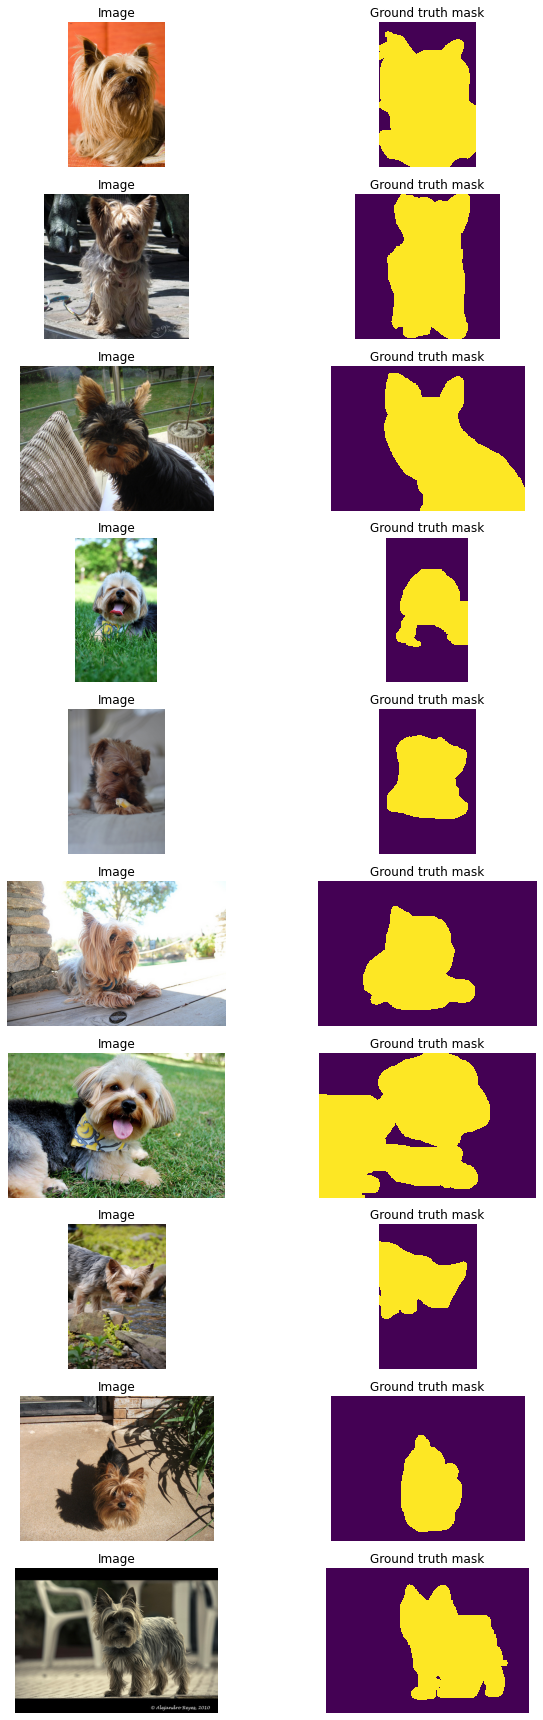

In [9]:
display_image_grid(test_images_filenames, images_directory, masks_directory)

In [10]:
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image, mask

In [11]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)

val_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)

In [12]:
def visualize_augmentations(dataset, idx=0, samples=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(10, 24))
    for i in range(samples):
        image, mask = dataset[idx]
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest")
        ax[i, 0].set_title("Augmented image")
        ax[i, 1].set_title("Augmented mask")
        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()
    plt.tight_layout()
    plt.show()

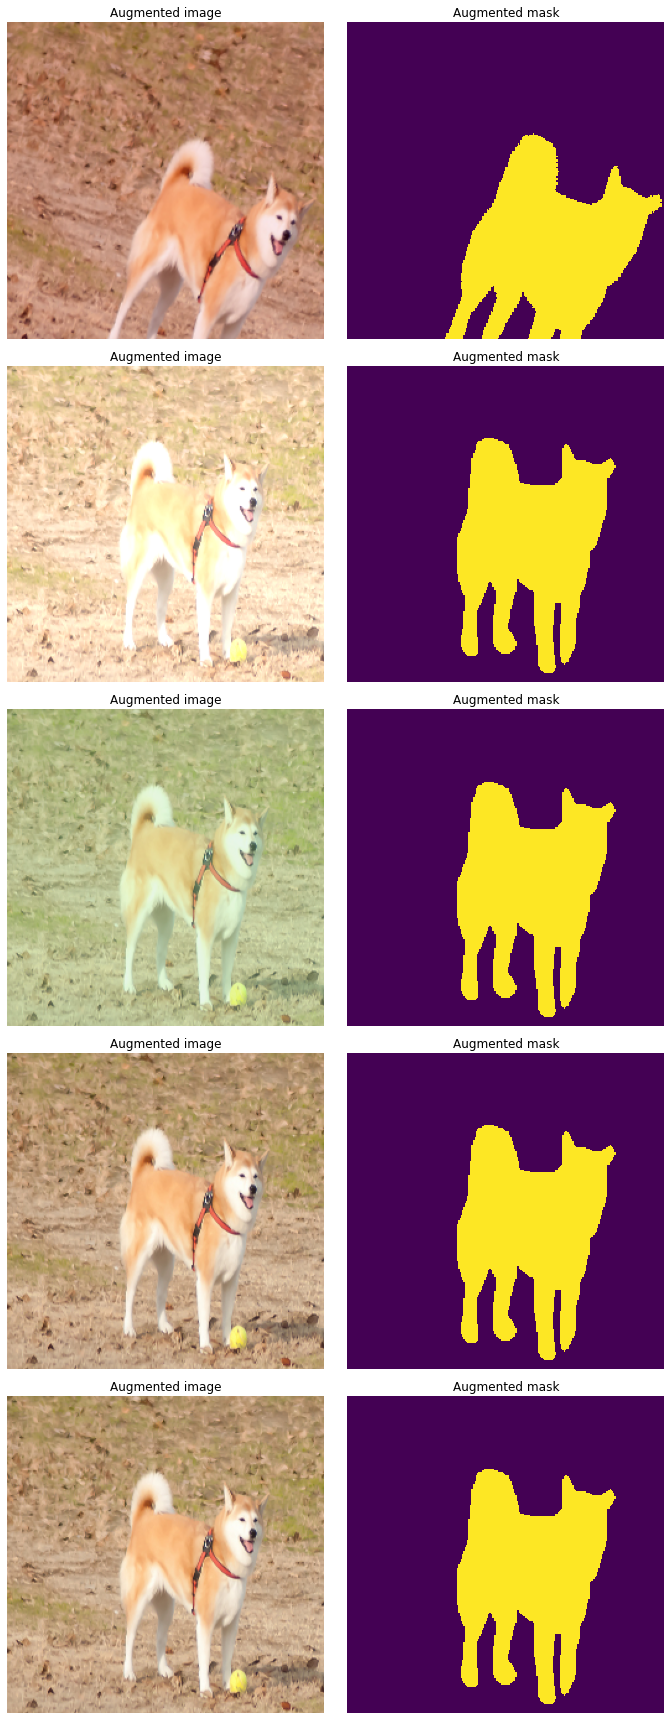

In [13]:
random.seed(42)
visualize_augmentations(train_dataset, idx=55)

In [14]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [15]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True)
        output = model(images).squeeze(1)
        loss = criterion(output, target)
        metric_monitor.update("Loss", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )

def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True)
            output = model(images).squeeze(1)
            loss = criterion(output, target)
            metric_monitor.update("Loss", loss.item())
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )

In [16]:
def train_and_validate(model, train_dataset, val_dataset, params):
    train_loader = DataLoader(
        train_dataset,
        batch_size=params["batch_size"],
        shuffle=True,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=params["batch_size"],
        shuffle=False,
        num_workers=params["num_workers"],
        pin_memory=True,
    )
    criterion = nn.BCEWithLogitsLoss().to(params["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])
    for epoch in range(1, params["epochs"] + 1):
        train(train_loader, model, criterion, optimizer, epoch, params)
        validate(val_loader, model, criterion, epoch, params)
    return model

In [17]:
def predict(model, params, test_dataset, batch_size):
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=params["num_workers"], pin_memory=True,
    )
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, (original_heights, original_widths) in test_loader:
            images = images.to(params["device"], non_blocking=True)
            output = model(images)
            probabilities = torch.sigmoid(output.squeeze(1))
            predicted_masks = (probabilities >= 0.5).float() * 1
            predicted_masks = predicted_masks.cpu().numpy()
            for predicted_mask, original_height, original_width in zip(
                predicted_masks, original_heights.numpy(), original_widths.numpy()
            ):
                predictions.append((predicted_mask, original_height, original_width))
    return predictions

In [18]:
class CBR(nn.Module):
    def __init__(self, in_channels,out_channels, kernel_size, **conv_params):
        super(CBR, self).__init__()
        self.conv = nn.Conv2d(in_channels =in_channels , out_channels=out_channels, kernel_size=kernel_size, stride=1, bias=False, **conv_params)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        
        return out

class ASPP(nn.Module):
    def __init__(self):
        super(ASPP, self).__init__()
        self.conv_1 = CBR(512, 256, 1, padding=0)
        self.conv_2 = CBR(512, 256, 3, dilation=6, padding = 6)
        self.conv_3 = CBR(512, 256, 3, dilation=12, padding = 12)
        self.conv_4 = CBR(512, 256, 3, dilation=18, padding = 18)
        self.conv_5 = CBR(1024, 256, 1, padding = 0)

    def forward(self, inp):
        out_1 = self.conv_1(inp)
        out_2 = self.conv_2(inp)
        out_3 = self.conv_3(inp)
        out_4 = self.conv_4(inp)

        out = torch.cat([out_1, out_2, out_3, out_4], axis=1)
        out = self.conv_5(out)

        return out

In [56]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
    
        self.conv_1 = CBR(3, 64, 3, padding=1)
        self.conv_2 = CBR(64, 64, 3, padding=1)
        self.conv_3 = CBR(64, 128, 3, padding=1)
        self.conv_4 = CBR(128, 128, 3, padding=1)
        self.conv_5 = CBR(128, 256, 3, padding=1)
        self.conv_6 = CBR(256, 256, 3, padding=1)
        self.conv_7 = CBR(256, 512, 3, padding=1)
        self.conv_8 = CBR(512, 512, 3, padding=1)
        self.conv_9 = CBR(512, 512, 3, padding=1)
        self.conv_10 = CBR(512, 512, 3, padding=1)

        self.conv_11 = CBR(256, 48, 1, padding=0)
        self.conv_11_1 = CBR(128, 24, 1, padding=0)
        self.conv_12 = CBR(304,256, 3, padding=1)
        self.conv_13 = CBR(256, 128, 3, padding=1)
        self.conv_14 = nn.Conv2d(in_channels =152 , out_channels=1, kernel_size=1)

        self.maxpool = nn.MaxPool2d(2, 2)

        self.aspp = ASPP()

    def forward(self, inp):

        out = self.conv_1(inp)
        out = self.conv_2(out)
        out = self.maxpool(out)
        out = self.conv_3(out)
        out = self.conv_4(out)
        out_enc_first = out
        out = self.maxpool(out)
        out = self.conv_5(out)
        out = self.conv_6(out)
        out_enc_mid = out
        out = self.maxpool(out)
        out = self.conv_7(out)
        out = self.conv_8(out)
        out = self.maxpool(out)
        out = self.conv_9(out)
        out = self.conv_10(out)

        out = self.aspp(out)
        out = nn.UpsamplingBilinear2d(size = out_enc_mid.shape[2:4])(out)

        out_enc_mid = self.conv_11(out_enc_mid)

        out = torch.cat([out, out_enc_mid], axis=1)

        out = self.conv_12(out)
        out = self.conv_13(out)
        out = nn.UpsamplingBilinear2d(size = out_enc_first.shape[2:4])(out)

        out_enc_first = self.conv_11_1(out_enc_first)

        out = torch.cat([out, out_enc_first], axis=1)

        out = self.conv_14(out)
        
        out = nn.UpsamplingBilinear2d(size = inp.shape[2:4])(out)

        return out

In [57]:
params = {
    "model": "UNet11",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 16,
    "num_workers": 4,
    "epochs": 10,
}

In [58]:
def create_model(params):
    # model = getattr(ternausnet.models, params["model"])(pretrained=True)
    model = Model()
    model = model.to(params["device"])
    return model

In [59]:
model = create_model(params)

In [24]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=e4a556a830c179e4bfe7371bbebb053ec8294104315956b4b6901e7565dd38ec
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [60]:
from torchviz import make_dot

x = torch.rand(64, 3, 100, 100).cuda()
y = model(x)

make_dot(y.mean(), params=dict(model.named_parameters())).render("rnn_torchviz1", format="png")

'rnn_torchviz1.png'

In [61]:
model = train_and_validate(model, train_dataset, val_dataset, params)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch: 10. Validation. Loss: 0.178: 100%|██████████| 86/86 [00:19<00:00,  4.31it/s]


In [62]:
class OxfordPetInferenceDataset(Dataset):
    def __init__(self, images_filenames, images_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = tuple(image.shape[:2])
        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]
        return image, original_size

In [63]:
test_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), ToTensorV2()]
)
test_dataset = OxfordPetInferenceDataset(test_images_filenames, images_directory, transform=test_transform,)

In [64]:
predictions = predict(model, params, test_dataset, batch_size=16)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [65]:
predicted_masks = []
for predicted_256x256_mask, original_height, original_width in predictions:
    full_sized_mask = A.resize(
        predicted_256x256_mask, height=original_height, width=original_width, interpolation=cv2.INTER_NEAREST
    )
    predicted_masks.append(full_sized_mask)


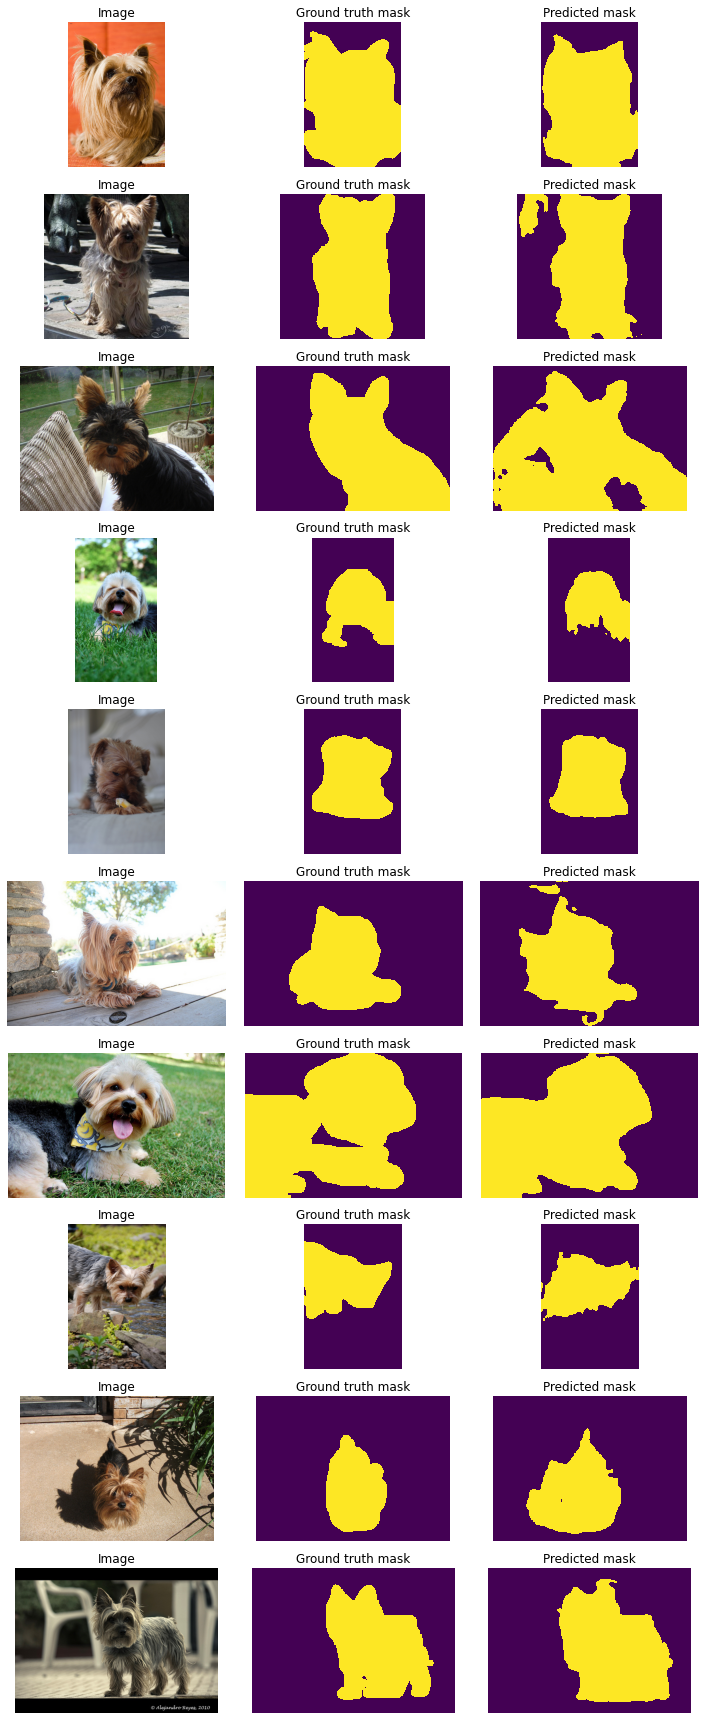

In [66]:
display_image_grid(test_images_filenames, images_directory, masks_directory, predicted_masks=predicted_masks)

In [31]:
torch.save (model, "model_segment.pth")